# Experimenting with various Kernel Combinations

## Matern with Sum of Sine amplitudes

Here I will be experimenting with a range of different kernel combinations, to see which one is able to model sunspot number the best.

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
import theano.tensor as tt

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
df = pd.read_csv('../../../Data/Savitzky-Golay Data/SVG_poly1.csv') # importing data for SVG polyorder = 1

In [18]:
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, A1, A2, T1, T2, phi1, phi2):
        self.A1 = A1
        self.A2 = A2
        self.T1 = T1
        self.T2 = T2
        self.phi1 = phi1
        self.phi2 = phi2
        
    def __call__(self, t):
        return self.A1 * np.sin(2 * np.pi * (t - self.phi1) / self.T1) + self.A2 * np.sin(2 * np.pi * (t - self.phi2) / self.T2)

## Data Preprocessing

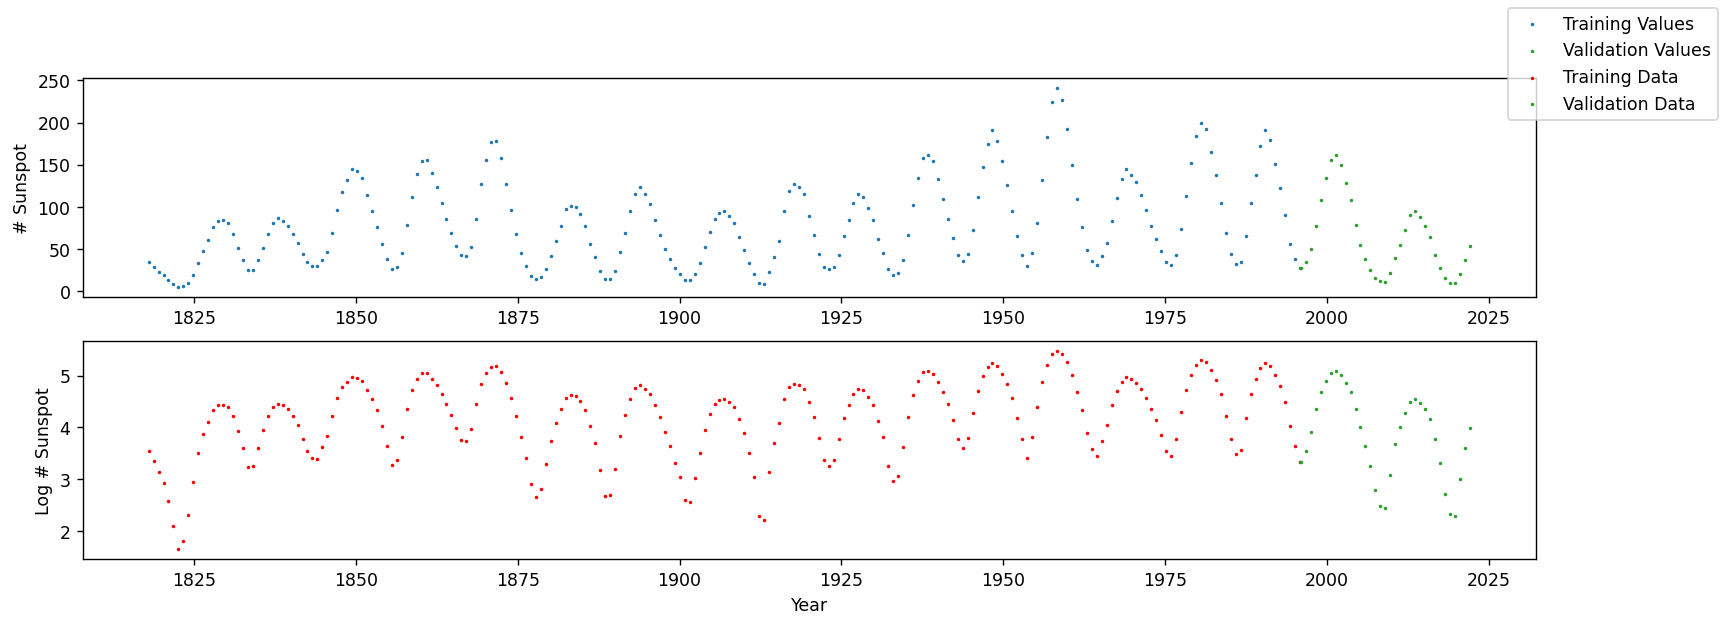

In [19]:
limit = 65000 # end point of full data when training
skips = 280 # number of points skipped

train_data = df.iloc[:limit:skips] 
validation_data = df.iloc[limit::skips]

training_values = (train_data.Year.values).reshape(-1,1), train_data.Sunspot_Number.values
validation_values = (validation_data.Year.values).reshape(-1,1), validation_data.Sunspot_Number.values

training_data = training_values[0], np.log(training_values[1]) 
validation_data = validation_values[0], np.log(validation_values[1])

# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].scatter(validation_values[0], validation_values[1], label='Validation Values', s=1, color='tab:green')
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].scatter(validation_data[0], validation_data[1], label='Validation Data', s=1, color='tab:green')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

## GP Regression

In [20]:
# Define the Gaussian Process
with pm.Model() as model:

    # Define the phase of the sinusoidal mean
    phi1 = pm.Uniform('phi1', 0, 10) 
    
    # Define the phase of the sinusoidal mean
    phi2 = pm.Uniform('phi2', 0, 10)
    
    # Define the amplitude of the sinusoidal mean
    A1 = pm.Uniform('A1', 0, 500) 
    
    # Define the amplitude of the sinusoidal mean
    A2 = pm.Uniform('A2', 0, 500)
    
    # Define the amplitude of the sinusoidal mean
    T1 = pm.Uniform('T1', 0, 50) 
    
    # Define the amplitude of the sinusoidal mean
    T2 = pm.Uniform('T2', 0, 50)
     
    # Define the offset of the sinusoidal mean
    offset = pm.Uniform('offset', 0, 100) 
    
    # Define the `Period' 
    period = pm.Uniform('period', 9, 12)
    
    # Define the `length scale 1' of the periodic kernel
    length_scale1 = pm.Uniform('Length Scale 1', 0, 5)  
    
    # Define the `length_scale 2' of the squared-exponential kernel 
    length_scale2 = pm.Uniform('Length Scale 2', 9, 15)
    
    # Define the `Standard deviation' 
    sigma = pm.Uniform('$\sigma$', 0.0, 1)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_Matern = pm.gp.cov.Matern32(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov = cov_Matern * cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(A1, A2, T1, T2, phi1, phi2)
    
    gp = pm.gp.Marginal(cov_func=cov, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a mo

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, Length Scale 2, Length Scale 1, period, offset, T2, T1, A2, A1, phi2, phi1]


ValueError: Not enough samples to build a trace.

In [ ]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);
#plt.savefig('gp post.png'); 

In [ ]:
X_new = validation_data[0]
with model:
    fnew = gp.conditional("f_taylor1", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_taylor1"])#

In [ ]:
from pymc3.gp.util import plot_gp_dist

# Sampling predictions
mu = np.exp(np.mean(ppc['f_taylor1'], axis=0))
std = np.exp(np.std(ppc['f_taylor1'], axis=0))

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_taylor1']), X_new, palette="Blues")
# np.exp() to return log value to normal value

plt.scatter(X_new, mu, color = 'tab:green', label='Mean prediction')
# plot original data and GP
plt.plot(validation_data[0], np.exp(validation_data[1]), "or", ms=3, alpha=1.0, label="Validation Data")
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
#plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

In [ ]:
observed = np.exp(validation_data[1])

# Standard Deviation of Data
std_data = np.std(observed) # std
normalised_std_data = np.array(std_data / np.mean(observed))

# Standard Deviation of Prediction
std_pred = np.std(mu) # std
normalised_std_pred = np.array(std_pred / np.mean(mu))

# Correlation
correlation = np.array(np.corrcoef(observed, mu)[0, 1])

print(f'The normalised standard deviation of the data is {normalised_std_data:.3f}')
print(f'The normalised standard deviation of the forecast is {normalised_std_pred:.3f}, and the correlation is {correlation:.3f}.')

In [10]:
''' Saving the Data '''
data = {"Metric": ["Standard Deviation (Normalised)", "Correlation Coefficient"], "Value": [normalised_std_pred, correlation]}
df = pd.DataFrame(data)
#df.to_csv("../../../Data/Taylor Diagram Data/GP_SE_plus_periodic.csv", index=False)